## Table of Contents

* [Introduction](#Introduction)
* [Data Import and Analysis](#Data-Import-and-Analysis)
* [BiLSTM-CRF](#Model-Building-LSTM-and-CRF)
 * [Data Preprocessing](#Data-Preprocessing)
 * [Model Building](#Model-Building)
 * [Evaluation](#Evaluation)
 * [Conclusion](#Conclusion)
* [OverSampling and BERT](#OverSampling-and-BERT)
 * [Data Preprocessing](#Oversampling-and-Preprocessing)
 * [Model Building](#Bert-Modeling)
 * [Evaluation](#BERT-Evaluation)
 * [Conclusion](#BERT-Conclusion)




# Introduction

### Named Entity Recognition

Named entity recognition (NER) is a task in natural language processing (NLP) that aims to identify and classify named entities in text. Named entities can be people, organizations, locations, or other entities. NER is a challenging task because the boundaries of named entities are often ambiguous and can be difficult to identify.

In this notebook, we will build a NER model using a combination of BiLSTM-CRF and BERT oversampling.

* BiLSTM-CRF is a well-known model for NER that has been shown to achieve state-of-the-art results.
* BERT is a pre-trained language model that has been shown to be effective for a variety of NLP tasks, including NER.

We will oversample the minority classes in our dataset to address the class imbalance problem. Class imbalance is a common problem in NER datasets, and it can make it difficult for the model to learn to identify the minority classes. Oversampling the minority classes will help the model to learn to identify these classes more accurately.

We will evaluate our model on the Given dataset. We will use the F1 score to measure the performance of our model.

The code in this notebook is well-documented and easy to follow. We have also included visualizations to help explain our results.

We hope that this notebook will be helpful for others who are interested in building NER models.


# Data Import and Analysis

In [5]:
#! pip install gensim

In [6]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
df=pd.read_csv('/kaggle/input/entity-annotated-corpus/ner_dataset.csv', encoding= 'unicode_escape')

In [8]:
df['Sentence #']=df['Sentence #'].ffill()

In [9]:
# %pip install datasets transformers
# %pip install tensorflow-addons

In [10]:
# import pandas as pd
# column_names = ['Token', 'POS']
# df_train = pd.read_csv("wnut 16.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_test = pd.read_csv("wnut 16test.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_train.head()

In [11]:
df=df[['Sentence #','Word','Tag']]
df.rename(columns={'Sentence #':'Sentence','Word':'Token','Tag':'POS'},inplace=True)

In [12]:
#df

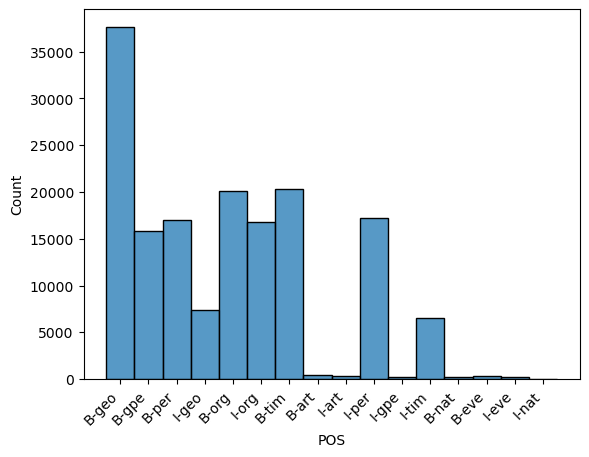

In [13]:
sns.histplot(df[df['POS']!='O']['POS'])
plt.xticks(rotation=45, ha='right')
plt.show()

Clearly there is imbalance in the dataset. Person, Other and loc has the highest count compare to other tags. We will take care of that in loss

In [14]:
df.info() #There seems to be no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Token     1048575 non-null  object
 2   POS       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [15]:
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Token'].nunique()))

Number of sentences are 47959
Number of Vocabs are 35178


# Model Building LSTM and CRF

## Data Preprocessing

In [12]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [13]:
df['Token']=df['Token'].str.lower()

In [14]:
sentence_all = [(list(zip(group['Token'], group['POS']))) for _, group in df.groupby('Sentence')]

In [15]:
sentence_all[0] #1st Sentence

[('thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('london', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('british', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [16]:
# sentences = []
# for sample in sentence_all:
#   sentence = [i[0] for i in sample]
#   sentences.append(sentence)

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=df['Token'].nunique(), lower=True)
# tokenizer.fit_on_texts(sentences)

In [17]:
#tokenizer.shape

In [18]:
#tokenizer.word_index.items()

In [19]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [20]:
#BATCH_SIZE

In [21]:
! pip install keras_preprocessing

In [22]:
words = list(set(df['Token'].values))
tags = list(set(df["POS"].values))

In [23]:
'thousands'in words

True

In [24]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}


In [25]:
#'thousands' in list(word2idx.keys())

In [29]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19600 words (12219 misses)


In [33]:
#! pip install keras_preprocessing

In [34]:
#Tagging word to index and tag to index

#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  iranian officials say they expect to get access to sealed sensitive parts of the plant wednesday , after an iaea surveillance system begins functioning .

 
Raw Label:
  B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O

 
After processing, sample:
 [20370 28171  4869 19204 12444  2401  7975 29002 30425 10949  3284 20602
 31163   889  8972 10949 24605 28171 29106 31704  7703  6467 21602 25426
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [35]:
#sentence_all

In [36]:
len(word2idx)

31819

In [37]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

In [38]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [39]:
#! pip install tensorflow_addons

In [40]:
# !pip install tensorflow-addons
# !pip install tensorflow==2.0.0-beta1

## Model Building

In [41]:
#len(word2idx)

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(18, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 75, 300)          9545700   
                                                                 
 bidirectional (Bidirectiona  (None, 75, 100)          140400    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 75, 200)          160800    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 75, 100)          100400    
 nal)                                                            
                                                             

## Evaluation

In [43]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=20,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20
675/675 [==============================] - ETA: 0s - loss: 0.3776
Epoch 1: val_loss improved from inf to 0.14341, saving model to ner_crf.h5
675/675 [==============================] - 63s 55ms/step - loss: 0.3776 - val_loss: 0.1434
Epoch 2/20
674/675 [============================>.] - ETA: 0s - loss: 0.0977
Epoch 2: val_loss improved from 0.14341 to 0.07075, saving model to ner_crf.h5
675/675 [==============================] - 30s 44ms/step - loss: 0.0977 - val_loss: 0.0707
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0561
Epoch 3: val_loss improved from 0.07075 to 0.04759, saving model to ner_crf.h5
675/675 [==============================] - 30s 44ms/step - loss: 0.0561 - val_loss: 0.0476
Epoch 4/20
675/675 [==============================] - ETA: 0s - loss: 0.0384
Epoch 4: val_loss improved from 0.04759 to 0.03631, saving model to ner_crf.h5
675/675 [==============================] - 30s 44ms/step - loss: 0.0384 - val_loss: 0.0363
Epoch 5/20
674/6

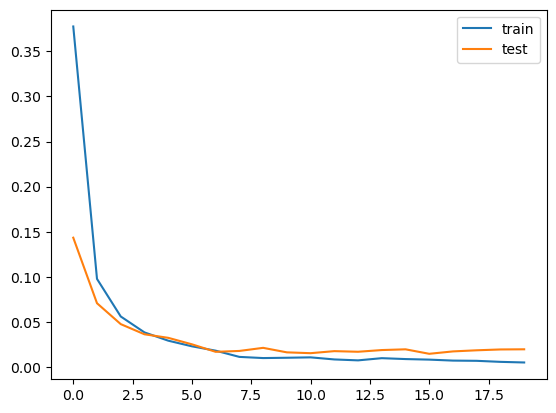

In [44]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Since it's still reducing there is a chance it will reduce more with more hyperparam tuning but loss of 0.02 for train and 0.14 with test looks great

150/150 [==============================] - 9s 12ms/step


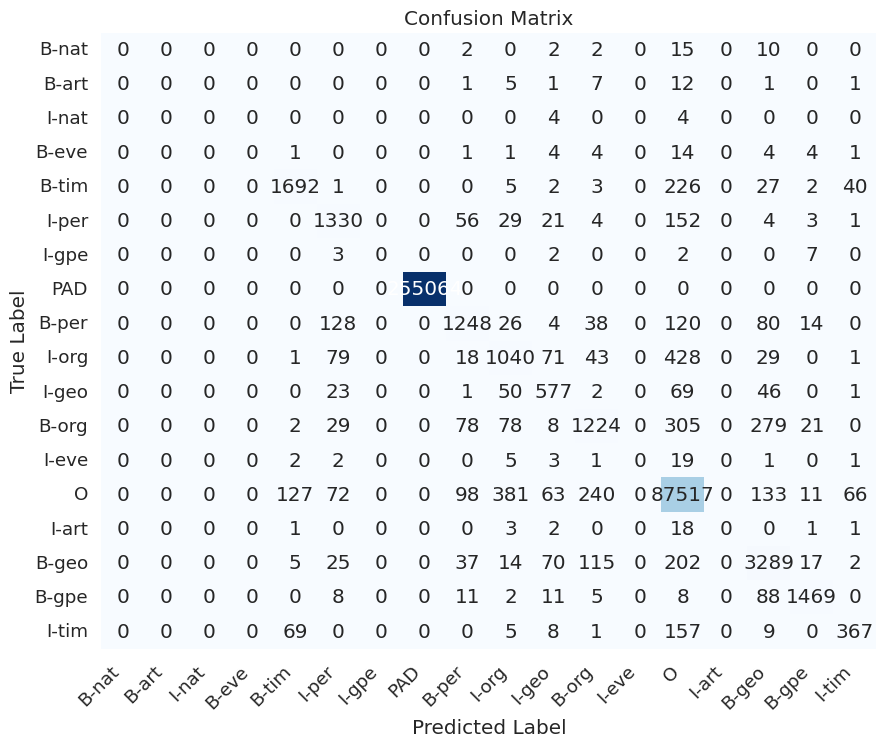

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [46]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                precision    recall  f1-score   support

       B-nat       0.00      0.00      0.00         0
       B-art       0.00      0.00      0.00         0
       I-nat       0.00      0.00      0.00         0
       B-eve       0.00      0.00      0.00         0
       B-tim       0.85      0.89      0.87      1900
       I-per       0.83      0.78      0.81      1700
       I-gpe       0.00      0.00      0.00         0
         PAD       1.00      1.00      1.00    255064
       B-per       0.75      0.80      0.78      1551
       I-org       0.61      0.63      0.62      1644
       I-geo       0.75      0.68      0.71       853
       B-org       0.60      0.72      0.66      1689
       I-eve       0.00      0.00      0.00         0
           O       0.99      0.98      0.98     89268
       I-art       0.00      0.00      0.00         0
       B-geo       0.87      0.82      0.85      4000
       B-gpe       0.92      0.95      0.93      1549
  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I can see that due to imbalance there are some category with less f1 score. We have used SigmoidFocalCrossEntropy to handle imbalance. We could further use either re-sampling method or more training methods

## Conclusion

In [47]:
import numpy as np

def get_pos_tags(sentence):
    # Tokenize the sentence
    tokens = sentence.lower().split()

    # Convert tokens to word indices
    word_indices = [word2idx.get(token, word2idx["UNK"]) for token in tokens]

    # Pad the sequence
    padded_sequence = pad_sequences([word_indices], maxlen=MAX_LEN, padding="post", value=word2idx["PAD"])

    # Make predictions
    predictions = model.predict(padded_sequence)[0]

    # Convert predictions to POS tags
    pos_tags = [idx2tag[np.argmax(pred)] for pred in predictions]

    return list(zip(tokens, pos_tags))

# Example usage
input_sentence = "I wanted to go to Disney Land"
output = get_pos_tags(input_sentence)

# Print the output
for token, pos_tag in output:
    print(f"Token: {token:<10} Predicted POS: {pos_tag}")


1/1 [==============================] - 0s 28ms/step
Token: i          Predicted POS: O
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: disney     Predicted POS: B-org
Token: land       Predicted POS: I-org


This is the prediction of the sentence

# OverSampling and BERT

## Oversampling and Preprocessing 

In [16]:
# ! pip install transformers
# ! pip install plotly


In [17]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [18]:
# sentence = df.groupby("Sentence")["Token"].apply(list).values
# #pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
# tag = df.groupby(by = 'Sentence')['POS'].apply(list).values

In [19]:
# Over Sampling
lst = [df]
max_size = 1356
for class_index, group in df.groupby('POS'):
        if len(group)< max_size:
            lst.append(group.sample(max_size-len(group), replace=True))
train_sample = pd.concat(lst)

In [20]:
train_sample=train_sample.sort_values(by='Sentence')

In [21]:
# Token and POS Encoding
def process_data(df):
    enc_pos = preprocessing.LabelEncoder()
    #enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])

    sentences = df.groupby("Sentence")["Token"].apply(list).values
    pos = df.groupby("Sentence")["POS"].apply(list).values
    return sentences, pos, enc_pos

sentence,pos,enc_pos = process_data(train_sample.copy())

/tmp/ipykernel_28/2399445221.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])


In [22]:
#pos

In [23]:
# Using BERT Auto-Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 256
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [24]:
# Train test split
X_train,X_test,y_train,y_test = train_test_split(sentence,pos,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43163,), (4796,), (43163,), (4796,))

In [25]:
X_train

array([list(['.', 'cracking', 'crime', 'corporate', 'on', 'down', 'are', 'that', 'insisted', 'officials', 'Kremlin', 'they']),
       list(['.', 'agenda', 'the', 'top', 'to', 'likely', 'also', 'Coast', 'Ivory', 'in', 'peace', 'faltering', 'and', 'region', 'Darfur', 'western', "'s", 'Sudan', 'in', 'conflict', 'The', 'process', 'the', 'were']),
       list(['a', 'meeting', 'with', 'an', 'embassy', 'from', "'s", 'at', '.', 'official', 'concerns', 'Burma', 'Beijing', 'The', 'Chinese', 'foreign', 'ministry', 'said', 'on', "'s", 'its', 'Web', 'Wei', 'Saturday', 'consular', 'site', 'affairs', 'department', 'chief', 'Wei', 'conveyed', 'that']),
       ...,
       list(['war', 'Milosevic', 'been', 'on', 'trial', 'at', 'the', 'United', 'Nations', 'had', 'crime', 'in', 'tribunal', '.', '1990s', 'the', 'in', 'wars', 'Balkan', 'the', 'in', 'role', 'for', 'humanity', 'his', 'crimes', 'the', 'Hague', 'facing', 'against', 'than', '60', 'more', 'of', 'war', 'crimes', 'and', 'counts']),
       list(['an

In [26]:
# Calling tokenization function
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 4796/4796 [00:01<00:00, 2758.81it/s]


In [27]:
#val_input_ids

In [28]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{256}

In [29]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (MAX_LEN-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{256}

In [30]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (MAX_LEN-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{256}

In [31]:
#train_tag[0].shape

## Bert Modeling

In [32]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(22,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [33]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [34]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [36]:
early_stopping = EarlyStopping(mode='min',patience=3)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 5,batch_size = 32,callbacks = early_stopping,verbose = True)

Epoch 1/5
1349/1349 [==============================] - 1382s 989ms/step - loss: 0.0855 - accuracy: 0.9783 - val_loss: 0.0399 - val_accuracy: 0.9877
Epoch 2/5
1349/1349 [==============================] - 1364s 1s/step - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0280 - val_accuracy: 0.9912
Epoch 3/5
1349/1349 [==============================] - 1364s 1s/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.0232 - val_accuracy: 0.9928
Epoch 4/5
1349/1349 [==============================] - 1333s 988ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0205 - val_accuracy: 0.9938
Epoch 5/5
1349/1349 [==============================] - 1366s 1s/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.0190 - val_accuracy: 0.9944


## BERT Evaluation

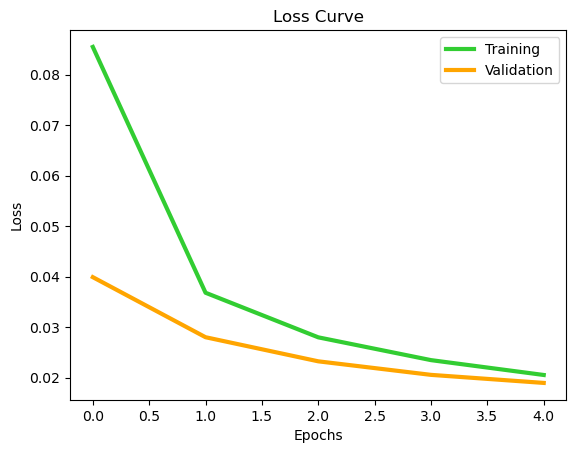

In [37]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history_bert.history['loss'],linewidth=3,color='limegreen')
plt.plot(history_bert.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

150/150 [==============================] - 53s 330ms/step


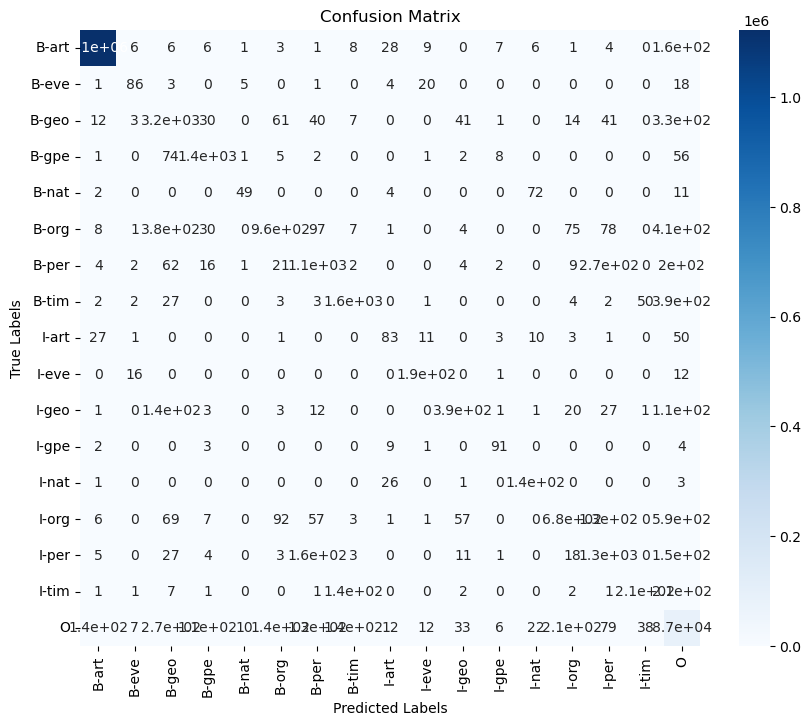

In [38]:
predictions = model.predict([val_input_ids, val_attention_mask])
predicted_labels = np.argmax(predictions, axis=2)
true_labels_flat = np.concatenate(test_tag)
predicted_labels_flat = np.concatenate(predicted_labels)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_flat, predicted_labels_flat)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sns
label_names = enc_pos.classes_  # Assuming `enc_pos` is the label encoder used in your code

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [39]:
y_pred = np.argmax(model.predict([val_input_ids, val_attention_mask]), axis=2)
y_pred_labels = enc_pos.inverse_transform(y_pred.reshape(-1))
y_true_labels = np.array(test_tag).flatten()
encoded_pred_labels = enc_pos.transform(y_pred_labels)
from sklearn.metrics import classification_report
label_names = enc_pos.inverse_transform(np.arange(len(enc_pos.classes_)))

report = classification_report(y_true_labels, encoded_pred_labels, target_names=label_names)
print(report)


150/150 [==============================] - 49s 329ms/step
              precision    recall  f1-score   support

       B-art       1.00      1.00      1.00   1122471
       B-eve       0.69      0.62      0.65       138
       B-geo       0.75      0.85      0.80      3797
       B-gpe       0.87      0.91      0.89      1592
       B-nat       0.73      0.36      0.48       138
       B-org       0.74      0.47      0.57      2055
       B-per       0.68      0.65      0.66      1668
       B-tim       0.83      0.76      0.80      2033
       I-art       0.49      0.44      0.46       190
       I-eve       0.77      0.87      0.82       221
       I-geo       0.72      0.55      0.62       713
       I-gpe       0.75      0.83      0.79       110
       I-nat       0.57      0.82      0.67       176
       I-org       0.66      0.40      0.50      1699
       I-per       0.67      0.77      0.72      1658
       I-tim       0.70      0.36      0.48       585
           O       0.97

Overall accuracy has not increased but the category wise accuracy has increased in many places. Oversampling and pretrained BERT has increase the score

## BERT Conclusion

In [41]:
# Sample sentence
sample_sentence = "I wanted to go to Disney in America"

# Tokenize the sample sentence
tokens = tokenizer.encode_plus(np.array(sample_sentence.split()),
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


input_ids=tokens['input_ids']
attention_mask=tokens['attention_mask']

# Convert tokens to input IDs and attention mask
# input_ids = tokenizer.convert_tokens_to_ids(tokens)
# attention_mask = [1] * len(input_ids)

# Pad the input IDs and attention mask
input_ids = input_ids #+ [0] * (MAX_LEN - len(input_ids))
attention_mask = attention_mask #+ [0] * (MAX_LEN - len(attention_mask))

# Reshape the input IDs and attention mask for prediction
input_ids = np.array(input_ids).reshape(1, -1)
attention_mask = np.array(attention_mask).reshape(1, -1)

# Make predictions
predictions = model.predict([input_ids, attention_mask])
predicted_labels = np.argmax(predictions, axis=2)[0]

# Map the predicted labels to their corresponding tag names
predicted_tags = enc_pos.inverse_transform(predicted_labels)

# Print the tokens and predicted POS tags
for token, tag in zip(sample_sentence.split(), predicted_tags):
    print(f"Token: {token:<10} Predicted POS: {tag}")

1/1 [==============================] - 0s 49ms/step
Token: I          Predicted POS: O
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: Disney     Predicted POS: B-org
Token: in         Predicted POS: O
Token: America    Predicted POS: I-geo
